In [24]:
import numpy as np
import random as rd
import math as mp
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull
from scipy.spatial import Delaunay
import csv

Qui di seguito vengono riportati vari calcoli fisici-matematici eseguiti sul modello Cucker-Smale ridimensionato senza la scatola

In [120]:
steps=1000
birds=100
ndim=3
timestep=0.001
step= 99899

#Variabili utili nel programma
C=0.003
D3=0.0015
E3=0.0003
B1=0.5
D0=1
E0=1
P1=10
Y1=10
D1=0.5
E1=0.5
S1=1.047
S2=1.57
alpha=1
beta=1

In [14]:
#Inizializzazione vettori posizioni e velocità
pos=np.zeros((birds,ndim))
vel=np.zeros((birds,ndim))

In [15]:
#Generazione random di posizioni e velocità iniziali
for i in range (birds):
    pos[i][0]=rd.randint(0,birds-1)
    pos[i][1]=rd.randint(0,birds-1)
    pos[i][2]=rd.randint(0,birds-1)
    vel[i][0]=rd.randint(1,birds-1)/100
    vel[i][1]=rd.randint(1,birds-1)/100
    vel[i][2]=rd.randint(1,birds-1)/100

In [16]:
#Funzione cutoff per S0 e S1
def cutoff(x,d,e):
    if x <= d:
        return 1
    elif x < (d + e):
        return 0.5+0.5*np.tan((1/(x-d))+(1/(x-(d+e))))
    else:
        return 0

In [17]:
#Calcolo w per la velocità come da articolo
def w(x,y,v):
    w1=Y1/pow(1+pow(np.linalg.norm(x-y),2),B1)
    w2=cutoff(np.linalg.norm(v),D1,E1)
    w3=(1-w2)
    w4=(np.dot((y-x),v))/((np.linalg.norm(y-x)*np.linalg.norm(v))) 
    w5=(1-cutoff(w4,np.cos(S2),np.cos(S1))) 
    return w1*(w2+w3*w5)

In [ ]:
#Applico formula Cucker-Smale e calcolo A,R,B e coefficiente di attrito e scrivo i risultati su un file di testo
for k in range (steps):
        N=1/(birds)
        N2=P1/(birds)
        N3=1/(birds)
        
        for i in range (birds):
            somma=0
            somma2=0
            somma3=0
            
            #A
            for j in range (birds):
                if i != j:
                    t1=(1-cutoff(np.linalg.norm(pos[i]-pos[j]),D0,E0))
                    t3=w(pos[i],pos[j],vel[i])
                    t4=(vel[j]-vel[i])
                    t = t1*t3*t4
                    somma=somma+t
            v1=N*somma
            
            #R
            for j in range (birds):
                if i != j:
                    d1=cutoff(np.linalg.norm(pos[i]-pos[j]),D0,E0)
                    d2=(pos[i]-pos[j])/(pow(1+pow(np.linalg.norm(pos[i]-pos[j]),2),B1))
                    d=d1*d2
                    somma2=somma2+d
            v2=N2*somma2 
        
            #B
            K=np.array([0,0,-1])
            for j in range (birds):
                if i != j:
                    d3=1/(1+pow(np.linalg.norm(pos[i]-pos[j]),2))
                    somma3=somma3+d3
            pv3=N3*somma3
            v3=C*cutoff(pv3,D3,E3)*np.cross(vel[i],K)
                
            #Attrito    
            v4 = ((alpha-beta*pow(np.linalg.norm(vel[i]),2))*vel[i])
            
            vel[i]+= (v1 + v2 + v3 + v4)*timestep
            pos[i]+= vel[i]*timestep
            
            vel3D = open("Vel3D100.txt", "a+")
            pos3D = open("Pos3D100.txt", "a+")
            vel3D.write(str(vel[i][0]) + " " + str(vel[i][1]) + " " + str(vel[i][2]) + "\n")
            pos3D.write(str(pos[i][0]) + " " + str(pos[i][1]) + " " + str(pos[i][2]) + "\n")
            vel3D.close()
            pos3D.close()
            
        print(k)

In [124]:
#Per una maggiore precisione i calcoli vengono effettuati su Cucker-Smale senza scatola
#E riporati all'interno di file txt che vengono letti in automatico dal programma

vel_file = open("vel3D100classico_b5.txt")
pos_file = open("pos3D100classico_b5.txt")
read_vel = csv.reader(vel_file, delimiter=" ")
read_pos = csv.reader(pos_file, delimiter=" ")
file_vel = []
file_pos = []

for row in read_vel:
    file_vel.append(row)

for row1 in read_pos:
    file_pos.append(row1)
    
#Trasformo ciò che ho letto nei file in matrici numpy
file_vel = np.array(file_vel,dtype=float)
file_pos = np.array(file_pos,dtype=float)

#Eseguo questo calcolo per prendere solo gli uccelli ad un certo step fissato
cont=step
i=0
data_vel = np.zeros((birds, 3))
data_pos = np.zeros((birds, 3))
fine=cont+birds

while cont < (fine):
   data_vel[i]=file_vel[cont]
   data_pos[i]=file_pos[cont]
   cont+=1
   i+=1

In [125]:
#Calcolo u = velocità singolo uccello - velocità media ad un certo step
velstep=data_vel
U=np.zeros((birds,ndim))
VelMedia=np.mean(velstep,axis=0)
for j in range (birds):
    U[j] = velstep[j] - VelMedia
        
#controllo che u sia uguale a zero
controll= np.round(np.sum(U,axis=0),2)
print(controll)

[-0. -0.  0.]


In [126]:
#Funzione delta correlazione
def delta(sigma):
    if sigma == 0:
        return 1
    else:
        return 0
    
#Funzione correlazione C(r) per uno step
def correlation(r):
    velox=U
    posix=data_pos
    som=0
    somDelta=0
    for i in range (birds):
        for j in range (birds):
            if i != j:
                modvi=np.linalg.norm(velox[i])
                modvj=np.linalg.norm(velox[j])
                si=velox[i]/modvi
                sj=velox[j]/modvj
                r1=np.round(np.linalg.norm(posix[i]-posix[j]),0)
                delt=delta(r-r1)
                somj=np.dot(si,sj)*delt
                som = som + somj
                somDelta = somDelta + delt
    if somDelta == 0:
        return 0
    else:
        return (som / somDelta)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34


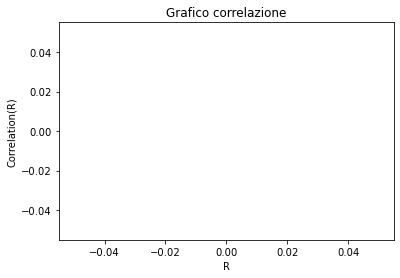

In [128]:
#Calcolo valore correlazione per ogni r dell'array 
massimo = 35
r2 = np.arange(0,massimo,1)
cor = []
r = []
for i in range (r2.size):
    result = np.round(correlation(r2[i]),2)
    if result != 0:
        cor.append(result)
        r.append(r2[i])
    print(i)
cor=np.array(cor)
r=np.array(r)

plt.plot(r, cor, marker = "o", color = 'red')
plt.title("Grafico correlazione")
plt.xlabel("R") 
plt.ylabel("Correlation(R)")
plt.show()

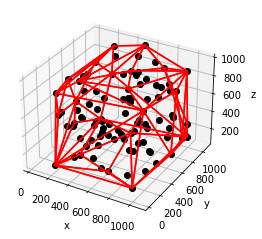

In [129]:
#Rappresentazione volume ad un certo step t
pts=data_pos
hull = ConvexHull(pts)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "r-")

# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))

plt.show()

In [130]:
#Calcolo polarizzazione come d'articolo per un certo step
array=np.zeros((birds,ndim))
for j in range (birds):
    norm = np.linalg.norm(data_vel[j])
    array[j] = data_vel[j] / norm
pol=np.linalg.norm(np.mean(array,axis=0))
print(pol)

0.8996226351778761


In [131]:
#Quantificazione dell'anisotropia dello stormo
position=data_pos
veloc=data_vel
mini=200
matrix=np.zeros((birds,3,3))
for i in range(birds):
    for j in range(birds):
        if i != j:
            val=np.linalg.norm(position[i]-position[j])
            if val < mini:
                j1=j
                mini=val
    ui=(veloc[i]/np.linalg.norm(veloc[i]))
    uj=(veloc[j1]/np.linalg.norm(veloc[j1]))
    matrix[i][0][0]=ui[0]*uj[0]
    matrix[i][0][1]=ui[0]*uj[1]
    matrix[i][0][2]=ui[0]*uj[2]
    matrix[i][1][0]=ui[1]*uj[0]
    matrix[i][1][1]=ui[1]*uj[1]
    matrix[i][1][2]=ui[1]*uj[2]
    matrix[i][2][0]=ui[2]*uj[0]
    matrix[i][2][1]=ui[2]*uj[1]
    matrix[i][2][2]=ui[2]*uj[2]
    mini=200

Mmedio=np.mean(matrix,axis=0)
autovalori, autovettori = np.linalg.eig(Mmedio)
low=min(autovalori)
index,=np.where(autovalori==low)
autovet=autovettori[index,:]
gamma=pow(autovet[0][0]*VelMedia[0]+autovet[0][1]*VelMedia[1]+autovet[0][2]*VelMedia[2],2)
print(gamma)

0.10416528598845678


In [135]:
vel_file_tot = open("vel3D100classico_b02.txt")
pos_file_tot = open("pos3D100classico_b02.txt")
read_vel_tot = csv.reader(vel_file_tot, delimiter=" ")
read_pos_tot = csv.reader(pos_file_tot, delimiter=" ")
file_vel_tot = []
file_pos_tot = []

for row in read_vel_tot:
    file_vel_tot.append(row)

for row1 in read_pos_tot:
    file_pos_tot.append(row1)
    
#Trasformo ciò che ho letto nei file in matrici numpy
file_vel_tot = np.array(file_vel_tot,dtype=float)
file_pos_tot = np.array(file_pos_tot,dtype=float)

In [136]:
velMedia_tot=np.linalg.norm(file_vel_tot, axis=1)
velMedia=np.zeros((steps,birds))
t=0
ucc=0
for i in range (velMedia_tot.size):
    velMedia[t][ucc]=velMedia_tot[i]
    ucc+=1
    if ucc==birds:
        ucc=0
        t+=1    

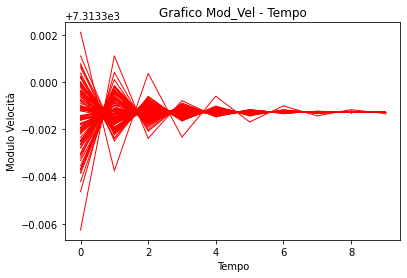

In [161]:
tempo=[]
for j in range (velMedia.shape[0]):
    tempo.append(j)
tempo=np.array(tempo)

tempo1=tempo[:10]
velMedia1=velMedia[:10,:]

plt.plot(tempo1, velMedia1, marker = "o", color = 'red',linewidth=1, markersize=0.11)
plt.title("Grafico Mod_Vel - Tempo")
plt.xlabel("Tempo") 
plt.ylabel("Modulo Velocità")

plt.show()